In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

In [2]:
import cv2
import itertools
import pathlib
import warnings
import os
import random
import time
import gc
from IPython.display import Markdown, display
from PIL import Image
from random import randint
warnings.filterwarnings("ignore") 

In [3]:
from imblearn.over_sampling import SMOTE


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [7]:
import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout,SeparableConv2D, Activation, BatchNormalization, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

In [8]:
def printmd(string):   
    display(Markdown(string))

In [9]:
np.random.seed(0)

In [10]:
def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [12]:
images = []
dirp = "/Users/felipepesantez/Documents/development/ML/datasets/time/train/"
for f in os.listdir(dirp):
    if "jpg" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else: 
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)
            
df = pd.DataFrame(images, columns = ["time", "path"])

from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

time_names = sorted(df.time.unique())
mapper_time_names = dict(zip(time_names, [t for t in range(len(time_names))]))
df["label"] = df["time"].map(mapper_time_names)
print(mapper_time_names)

{'1-00': 0, '1-05': 1, '1-10': 2, '1-15': 3, '1-20': 4, '1-25': 5, '1-30': 6, '1-35': 7, '1-40': 8, '1-45': 9, '1-50': 10, '1-55': 11, '10-00': 12, '10-05': 13, '10-10': 14, '10-15': 15, '10-20': 16, '10-25': 17, '10-30': 18, '10-35': 19, '10-40': 20, '10-45': 21, '10-50': 22, '10-55': 23, '11-00': 24, '11-05': 25, '11-10': 26, '11-15': 27, '11-20': 28, '11-25': 29, '11-30': 30, '11-35': 31, '11-40': 32, '11-45': 33, '11-50': 34, '11-55': 35, '12-00': 36, '12-05': 37, '12-10': 38, '12-15': 39, '12-20': 40, '12-25': 41, '12-30': 42, '12-35': 43, '12-40': 44, '12-45': 45, '12-50': 46, '12-55': 47, '2-00': 48, '2-05': 49, '2-10': 50, '2-15': 51, '2-20': 52, '2-25': 53, '2-30': 54, '2-35': 55, '2-40': 56, '2-45': 57, '2-50': 58, '2-55': 59, '3-00': 60, '3-05': 61, '3-10': 62, '3-15': 63, '3-20': 64, '3-25': 65, '3-30': 66, '3-35': 67, '3-40': 68, '3-45': 69, '3-50': 70, '3-55': 71, '4-00': 72, '4-05': 73, '4-10': 74, '4-15': 75, '4-20': 76, '4-25': 77, '4-30': 78, '4-35': 79, '4-40': 80, '

In [13]:
df.head()

,time,path,label
0,4-05,/Users/felipepesantez/Documents/development/ML...,73
1,12-20,/Users/felipepesantez/Documents/development/ML...,40
2,2-40,/Users/felipepesantez/Documents/development/ML...,56
3,5-25,/Users/felipepesantez/Documents/development/ML...,89
4,10-05,/Users/felipepesantez/Documents/development/ML...,13


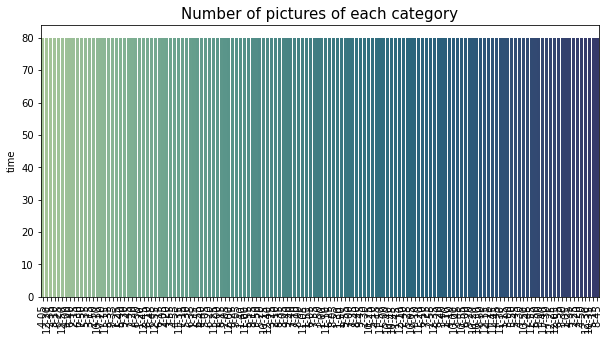

In [14]:
fc = df["time"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = fc.index, y = fc, palette = "crest")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

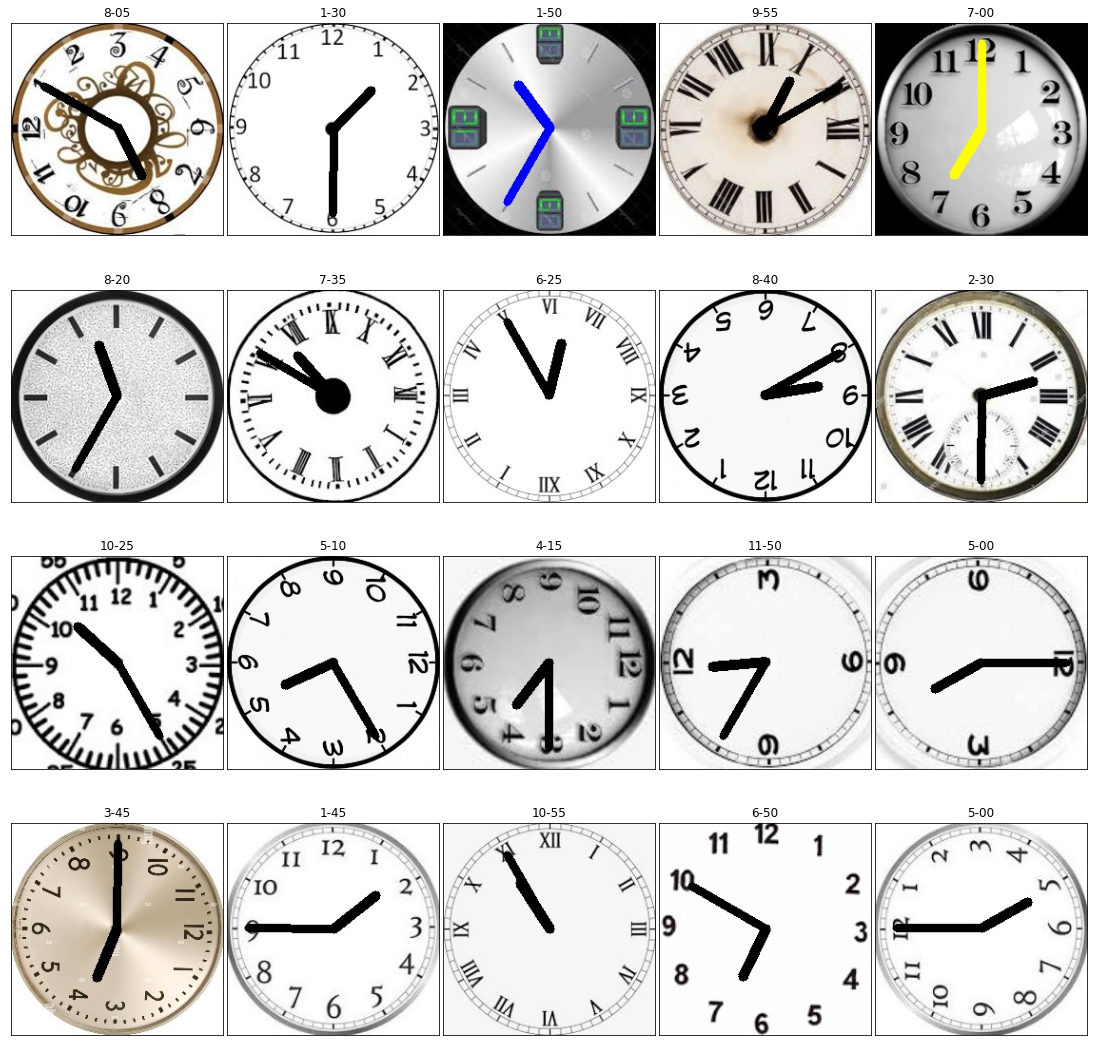

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i+20]))
    ax.set_title(df.time[i+20], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

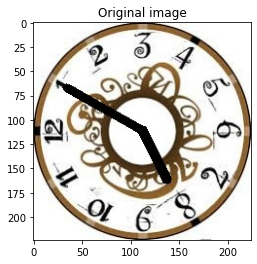

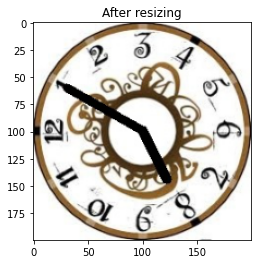

In [16]:
img = plt.imread(df.path[20])
plt.imshow(img)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(img, (200,200)))
plt.title("After resizing")
plt.show()

In [17]:
def cut_df(df, number_of_parts, part):

    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")
        
    number_imgs_each_part = int(df.shape[0]/number_of_parts)
    idx1 = (part-1) * number_imgs_each_part
    idx2 = part * number_imgs_each_part
    return df.iloc[idx1:idx2]

def load_img(df):

    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (200,200))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [18]:
def create_model():
    shape_img = (200,200,3)
    
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(mapper_time_names)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
    
    return model

In [19]:
def from_categorical(lst):
    
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2

def display_stats(y_test, pred):
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")
    
def plot_training(model):
    history = pd.DataFrame(model.history.history)
    history[["accuracy","val_accuracy"]].plot()
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()

In [20]:
model = create_model()
hists = []

divisor = 5

start_time = time.time()
X_train, y_train = load_img(cut_df(df,divisor,1))
y_train = to_categorical(y_train)

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)]

model.fit(X_train, y_train, batch_size=32, epochs=200, callbacks=callbacks, validation_split = 0.1, verbose = 1)
hists.append(model.history.history)
model.save("model.h5")

2022-09-17 14:11:21.135843: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-17 14:11:21.136127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/200


2022-09-17 14:11:23.464859: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-17 14:11:23.795918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


65/65 [==============================] - ETA: 0s - loss: 5.4165 - accuracy: 0.0101

2022-09-17 14:11:30.279026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to training_1/cp.ckpt
65/65 [==============================] - 7s 81ms/step - loss: 5.4165 - accuracy: 0.0101 - val_loss: 4.9698 - val_accuracy: 0.0043
Epoch 2/200
65/65 [==============================] - ETA: 0s - loss: 4.9745 - accuracy: 0.0092
Epoch 2: saving model to training_1/cp.ckpt
65/65 [==============================] - 4s 66ms/step - loss: 4.9745 - accuracy: 0.0092 - val_loss: 4.9716 - val_accuracy: 0.0000e+00
Epoch 3/200
65/65 [==============================] - ETA: 0s - loss: 4.9700 - accuracy: 0.0087
Epoch 3: saving model to training_1/cp.ckpt
65/65 [==============================] - 4s 68ms/step - loss: 4.9700 - accuracy: 0.0087 - val_loss: 4.9704 - val_accuracy: 0.0043
Epoch 4/200
65/65 [==============================] - ETA: 0s - loss: 4.9633 - accuracy: 0.0087
Epoch 4: saving model to training_1/cp.ckpt
65/65 [==============================] - 4s 65ms/step - loss: 4.9633 - accuracy: 0.0087 - val_loss: 4.9733 - val_accuracy: 0.0087
Epoch 5/200
65

In [21]:
gc.collect()

4509

In [22]:
time_model = time.time() - start_time
print(f"Time to train the model: {int(time_model)} seconds")


Time to train the model: 1424 seconds


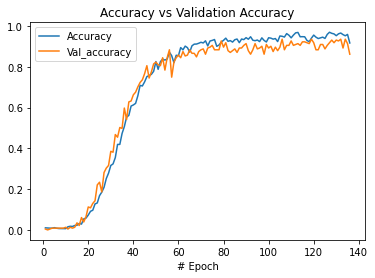

In [23]:
acc = []
val_acc = []
for i in range(len(hists)):
    acc += hists[i]["accuracy"]
    val_acc += hists[i]["val_accuracy"]
hist_df = pd.DataFrame({"# Epoch": [e for e in range(1,len(acc)+1)],"Accuracy": acc, "Val_accuracy": val_acc})
hist_df.plot(x = "# Epoch", y = ["Accuracy","Val_accuracy"])
plt.title("Accuracy vs Validation Accuracy")
plt.show()

In [24]:
X, y = load_img(cut_df(df, 20, 20))
#pred = model.predict_classes(X)
pred = np.argmax(model.predict(X), axis=1)
y_test = to_categorical(y)

display_stats(y_test, pred)

2022-09-17 14:35:13.891482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Result of the predictions using 576 test data ###

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.80      0.67      0.73         6
           2       1.00      1.00      1.00         1
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         1
           5       0.75      1.00      0.86         3
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         2
           8       1.00      0.50      0.67         6
           9       0.50      1.00      0.67         1
          10       1.00      1.00      1.00         2
          11       1.00      0.86      0.92         7
          12       0.43      1.00      0.60         3
          13       1.00      1.00      1.00         4
          14       0.86      0.86      0.86         7
          15       1.00      1.00      1.00         4
  

# Accuracy: 0.89236

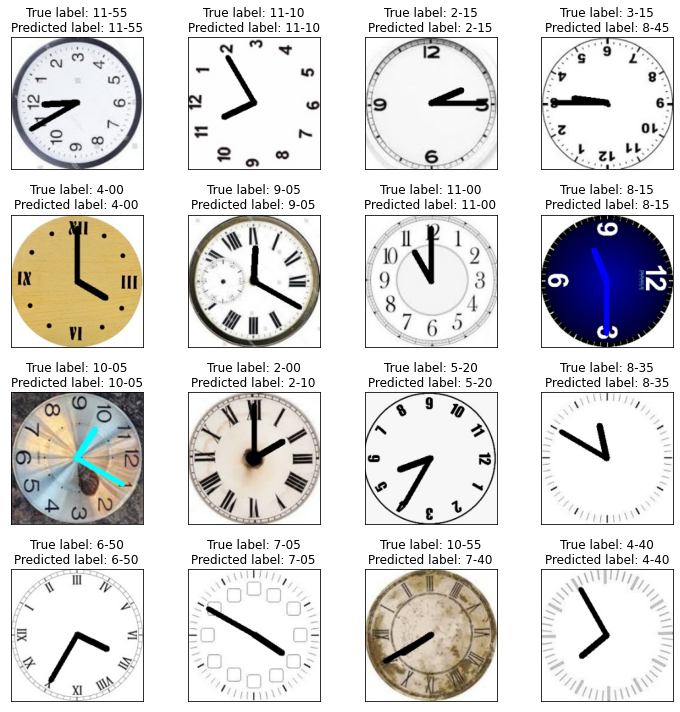

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X[-i])
    ax.set_title(f"True label: {time_names[y[-i]]}\nPredicted label: {time_names[pred[-i]]}")

plt.tight_layout()
plt.show()